<img src="http://www.exalumnos.usm.cl/wp-content/uploads/2015/06/Isotipo-Negro.gif" title="Title text" width="20%" height="20%" />


<hr style="height:2px;border:none"/>
<h1 align='center'> Binary Variational Semantic Hashing </h1>

<H3 align='center'> Extensión trabajo CIARP </H3>
<hr style="height:2px;border:none"/>

In [1]:
import numpy as np
import keras,gc, os, time, sys
from keras.layers import *
from keras.models import Sequential,Model
from keras import backend as K
from astropy.table import Table
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from PIL import Image
from scipy.special import expit

from base_networks import *
from utils import check_availability, load_imgs_mask

from utils import get_topK_labels,set_newlabel_list, enmask_data

np.random.seed(20)

/home/fmena/anaconda3/envs/tesis/lib/python3.5/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
/home/fmena/.local/lib/python3.5/site-packages/tensorflow/python/framework/dtypes.py:469: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/fmena/.local/lib/python3.5/site-packages/tensorflow/python/framework/dtypes.py:470: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/fmena/.local/lib/python3.5/site-package

## Load Data

### MNIST
---

Imágenes en blanco y negro de 28x28 píxeles, de números del 0 al 9, que dan orígen a las 10 clases del problema.

|Tipo set|Datos|Label|
|---|---|---|
|Entrenamiento|60000|10|
|Pruebas|10000|10|

In [2]:
name_dat = "MNIST"

(X_t, aux_t), (X_test, aux_test) = keras.datasets.mnist.load_data()
X_t = np.expand_dims(X_t, axis=-1)
X_test = np.expand_dims(X_test, axis=-1)

labels = ["0", "1", "2", "3", "4", "5", "6", "7", "8", "9"]
labels_t = np.asarray([labels[value] for value in aux_t])
labels_test = np.asarray([labels[value] for value in aux_test])
print("Datos de entrenamiento: ",len(X_t))
print("Datos de pruebas: ",len(X_test))

Datos de entrenamiento:  60000
Datos de pruebas:  10000


In [3]:
##concat all
X_t = np.concatenate((X_t,X_test),axis=0)
labels_t = np.concatenate((labels_t,labels_test),axis=0)
del X_test, labels_test
gc.collect()

##### 1000 imagenes de prueba... 
from utils import sample_test_mask
mask_train = sample_test_mask(labels_t, N=100, multi_label=False)

In [4]:
## creat test como dicen...
X_test = X_t[~mask_train]
X_t = X_t[mask_train]
labels_test = enmask_data(labels_t, ~mask_train)
labels_t = enmask_data(labels_t, mask_train)

gc.collect()
print("Cantidad de datos Entrenamiento: ",len(X_t))
print("Cantidad de datos Pruebas: ",len(X_test))

Cantidad de datos Entrenamiento:  69000
Cantidad de datos Pruebas:  1000


### CIFAR-10
---
Imágenes RGB pequeñas de  32x32 píxeles, de fotos naturales de distintos objetos.

|Tipo set|Datos|Label|
|---|---|---|
|Entrenamiento|50000|10|
|Pruebas|10000|10|

In [4]:
name_dat = "CIFAR-10"

(X_t, aux_t), (X_test, aux_test) = keras.datasets.cifar10.load_data()

labels = ["airplane", "automobile","bird", "cat","deer","dog","frog","horse","ship","truck"]
labels_t = np.asarray([labels[value[0]] for value in aux_t])
labels_test = np.asarray([labels[value[0]] for value in aux_test])
print("Datos de entrenamiento: ",len(X_t))
print("Datos de pruebas: ",len(X_test))

Datos de entrenamiento:  50000
Datos de pruebas:  10000


In [5]:
##concat all
X_t = np.concatenate((X_t,X_test),axis=0)
labels_t = np.concatenate((labels_t,labels_test),axis=0)
del X_test, labels_test
gc.collect()

##### 1000 imagenes de prueba... 
from utils import sample_test_mask
mask_train = sample_test_mask(labels_t, N=100, multi_label=False)

In [6]:
## creat test como dicen...
X_test = X_t[~mask_train]
X_t = X_t[mask_train]
labels_test = enmask_data(labels_t, ~mask_train)
labels_t = enmask_data(labels_t, mask_train)

gc.collect()
print("Cantidad de datos Entrenamiento: ",len(X_t))
print("Cantidad de datos Pruebas: ",len(X_test))

Cantidad de datos Entrenamiento:  59000
Cantidad de datos Pruebas:  1000


### CelebA
---
* Cantidad de datos totales: 202599
* Datos en plataforma Kaggle:https://www.kaggle.com/jessicali9530/celeba-dataset 

Imágenes RGB re-dimensionadas a 64x64 píxeles, de fotos naturales de rostros de celebridades. Una muestra es utilizada

|Tipo set|Datos|Label|
|---|---|---|
|Entrenamiento|xxx|40|
|Validación|xxx|40|
|Pruebas|xxx|40|

mask_av = check_availability(folder+"small_images/", labels_t)
np.savetxt("./Data/+"name_dat+"_mask_avail.txt", mask_av, fmt="%1i")

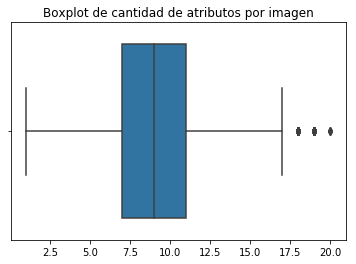

In [3]:
sns.boxplot(list(map(len,labels_t)))
plt.title("Boxplot de cantidad de topics por imagen")
plt.show()

In [10]:
name_dat = "CelebA"
mask_av = np.loadtxt("./Data/"+name_dat+"_mask_avail.txt").astype(bool)

folder = "../CelebA/"

part = pd.read_csv(folder+"list_eval_partition.csv")
mask_train = (part["partition"].values == 0)[mask_av]
mask_val = (part["partition"].values == 1)[mask_av]
mask_test = (part["partition"].values == 2)[mask_av]

df_atrr = pd.read_csv(folder+"list_attr_celeba.csv")[mask_av]
img_names = df_atrr["image_id"].values
labels = list(df_atrr.columns[1:])
print("Cantidad de labels: ",len(labels) )

N_total = len(df_atrr)
print("Cantidad de objetos: ",N_total )
aux = (df_atrr == 1).values
labels_t = np.asarray([list(df_atrr.columns[aux[value]]) for value in range(N_total)])
labels[:5]

Cantidad de labels:  40
Cantidad de objetos:  202599


['5_o_Clock_Shadow',
 'Arched_Eyebrows',
 'Attractive',
 'Bags_Under_Eyes',
 'Bald']

In [11]:
mask_used= np.ones(N_total, dtype=bool)

N_used = 80*1000 #o 150k??
idx_all = np.arange(0, N_total)
mask_used = np.zeros(N_total, dtype=bool)
mask_used[np.random.choice(np.arange(0, N_total), size=N_used, replace=False)] = 1
mask_used

#### get top-K labels data
* Elije 6, para realizar un enfoque mas centrado: http://openaccess.thecvf.com/content_cvpr_2017/papers/Shen_Learning_Residual_Images_CVPR_2017_paper.pdf:
* Elije 7: https://arxiv.org/pdf/1804.08882.pdf

In [4]:
new_labels = get_topK_labels(labels_t, labels, K=??)

labels_t = set_newlabel_list(new_labels, labels_t)
labels = new_labels
# y si quedan datos sin clase?
mask_used_t = np.asarray(list(map(len,labels_t))) != 0
print("Cantidad de objetos: ", np.sum(mask_used_t) )

sns.boxplot(list(map(len,labels_t)))
plt.title("Boxplot de cantidad de topics por imagen")
plt.show()

mask_used = mask_used_t

SyntaxError: invalid syntax (<ipython-input-4-0c039559b924>, line 1)

In [12]:
imgs_files = [folder+ "imgs_celebA/"+ name for name in img_names]

X_t = load_imgs_mask(imgs_files, mask_used, size=64) #images names to load
X_t.shape

El contador de lectura va en:  0
El contador de lectura va en:  10000
El contador de lectura va en:  20000
El contador de lectura va en:  30000
El contador de lectura va en:  40000
El contador de lectura va en:  50000
El contador de lectura va en:  60000
El contador de lectura va en:  70000
El contador de lectura va en:  80000
El contador de lectura va en:  90000
El contador de lectura va en:  100000
El contador de lectura va en:  110000
El contador de lectura va en:  120000
El contador de lectura va en:  130000
El contador de lectura va en:  140000
El contador de lectura va en:  150000
El contador de lectura va en:  160000
El contador de lectura va en:  170000
El contador de lectura va en:  180000
El contador de lectura va en:  190000
El contador de lectura va en:  200000


(202599, 64, 64, 3)

In [13]:
from utils import sample_test_mask
mask_train = sample_test_mask(labels_t, N=100, multi_label=True)

## creat test como dicen...
X_test = X_t[~mask_train]
X_t = X_t[mask_train]
labels_test = enmask_data(labels_t, ~mask_train)
labels_t = enmask_data(labels_t, mask_train)

gc.collect()
print("Cantidad de datos Entrenamiento: ",len(X_t))
print("Cantidad de datos Pruebas: ",len(X_test))

Cantidad de datos Entrenamiento:  198599
Cantidad de datos Pruebas:  4000


#create sets 
X_t = X_t.astype('float32')/255.
X_train = X_t[mask_train[mask_used]]
X_val = X_t[mask_val[mask_used]]
X_test = X_t[mask_test[mask_used]]

labels_train = enmask_data(labels_t, mask_train & mask_used)
labels_val = enmask_data(labels_t, mask_val & mask_used)
labels_test = enmask_data(labels_t, mask_test & mask_used)

del X_t,mask_train,mask_val,mask_test,mask_used
gc.collect()
print("Cantidad de datos Entrenamiento: ",len(X_train))
print("Cantidad de datos Validación: ",len(X_val))
print("Cantidad de datos Pruebas: ",len(X_test))

### NUSWIDE
---
* Cantidad de datos totales: 269648
* Datos utlizados (con imagenes disponibles a descargar): 169500
* Datos top-21 clases: 158383

Imágenes de eventos con 81 tópicos asociados, re-dimensionadas a 64x64.

|Tipo set|Datos|Label|
|---|---|---|
|Entrenamiento|xxx|81|
|Validación|xxx|81|
|Pruebas|xxx|81|

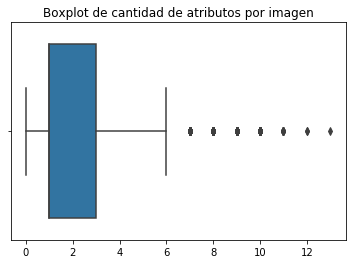

In [6]:
sns.boxplot(list(map(len,labels_t)))
plt.title("Boxplot de cantidad de atributos por imagen")
plt.show()

list_images = pd.read_csv(folder+"ImageList/Imagelist_downloaded.txt", header=None).iloc[:,0]
imgs_files = [value for value in list_images.values]

folder_imgs_name = folder+"small_images/"
mask_av = check_availability(folder_imgs_name, imgs_files, labels_t)
np.savetxt("./Data/"+name_dat+"_mask_avail.txt", mask_av, fmt="%1i")

mask_av

In [2]:
name_dat = "Nus-Wide"

folder = "../Dataset_NUSWIDE/"
folder_imgs_name = folder+"small_images/"

mask_av = np.loadtxt("./Data/"+name_dat+"_mask_avail.txt").astype(bool)

labels = pd.read_csv(folder+'Concepts81.txt',header=None).values.reshape(1,-1)[0]
print("Cantidad de labels: ",len(labels) )

labels_t = [[] for _ in range(269648)]
for concept in labels:
    aux = pd.read_csv(folder+"Groundtruth/AllLabels/Labels_"+concept+".txt",header=None)
    indexs_true = aux.loc[(aux==1).values[:,0]].index
    
    for value in indexs_true:
        labels_t[value].append(concept)
        
labels_t = enmask_data(labels_t, mask_av)
N_total = len(labels_t)
print("Cantidad de objetos: ",N_total )

labels_t[:5]

Cantidad de labels:  81
Cantidad de objetos:  169500


[['person'], ['person'], ['person'], ['person'], ['person']]

#### get top-K labels data

category with most data (sky) has = 61066, the top-K category (mountain) has = 4232
Cantidad de objetos:  158383


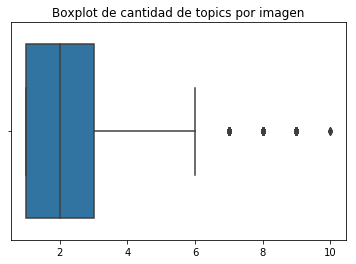

In [3]:
new_labels = get_topK_labels(labels_t, labels, K=21)

labels_t = set_newlabel_list(new_labels, labels_t)
labels = new_labels
# y si quedan datos sin clase?
mask_used_t = np.asarray(list(map(len,labels_t))) != 0

labels_t = enmask_data(labels_t, mask_used_t)
print("Cantidad de objetos: ", len(labels_t) )

sns.boxplot(list(map(len,labels_t)))
plt.title("Boxplot de cantidad de topics por imagen")
plt.show()

N_used = 80*1000 #o 150k??
idx_all = np.arange(0, N_total)
mask_used = np.zeros(N_total, dtype=bool)
mask_used[np.random.choice(np.arange(0, N_total), size=N_used, replace=False)] = 1
mask_used

In [4]:
list_images = pd.read_csv(folder+"ImageList/Imagelist_downloaded.txt", header=None).iloc[:,0]
imgs_files = [folder_imgs_name + value for value in list_images.values]
imgs_files = enmask_data(imgs_files, mask_av)

X_t = load_imgs_mask(imgs_files, mask_used_t, size=64) #images names to load
X_t.shape

El contador de lectura va en:  0
El contador de lectura va en:  10000
El contador de lectura va en:  20000
El contador de lectura va en:  30000
El contador de lectura va en:  40000
El contador de lectura va en:  50000
El contador de lectura va en:  60000
El contador de lectura va en:  70000
El contador de lectura va en:  80000
El contador de lectura va en:  90000
El contador de lectura va en:  100000
El contador de lectura va en:  110000
El contador de lectura va en:  120000
El contador de lectura va en:  130000
El contador de lectura va en:  140000
El contador de lectura va en:  150000
El contador de lectura va en:  160000


(158383, 64, 64, 3)

We sam-ple uniformly 100 images from each of the selected 21tags to form a query set of 2,100 images with the restserving as the training set. http://cfm.uestc.edu.cn/~fshen/SADH.pdf

In [5]:
mask_train = np.ones(len(X_t), dtype='bool')
mask_train[np.random.choice(np.arange(len(X_t)), size=10000, replace=False)] = 0

In [5]:
from utils import sample_test_mask
mask_train = sample_test_mask(labels_t, N=100, multi_label=True)

In [6]:
## creat test como dicen...
X_test = X_t[~mask_train]
X_t = X_t[mask_train]
labels_test = enmask_data(labels_t, ~mask_train)
labels_t = enmask_data(labels_t, mask_train)

gc.collect()
print("Cantidad de datos Entrenamiento: ",len(X_t))
print("Cantidad de datos Pruebas: ",len(X_test))

Cantidad de datos Entrenamiento:  156283
Cantidad de datos Pruebas:  2100


### Validation creation

Pre-process: División por 255

In [7]:
X_t = X_t.astype('float32')/255.0
X_test = X_test.astype('float32')/255.0

In [8]:
from sklearn.model_selection import train_test_split
#X_train, X_val, labels_train, labels_val  = train_test_split(X_t, labels_t, random_state=20,test_size=0.2)

X_train, X_val, labels_train, labels_val  = train_test_split(X_t, labels_t, random_state=20,test_size=len(X_test))

print("Cantidad de datos Entrenamiento: ",len(X_train))
print("Cantidad de datos Validación: ",len(X_val))
print("Cantidad de datos Pruebas: ",len(X_test))
del X_t, labels_t
gc.collect()

Cantidad de datos Entrenamiento:  154183
Cantidad de datos Validación:  2100
Cantidad de datos Pruebas:  2100


10

### Model Architecture
---
CNN
https://github.com/rtflynn/Cifar-Autoencoder

In [9]:
def REC_loss(x_true, x_pred):
    return K.mean( K.binary_crossentropy(x_true, x_pred), axis=(1,2,3))


0.0001

In [10]:
## GENERICO -- FOR ALL
aux_pre_E, shape = def_pre_encoder_CNN(X_train.shape[1:], 3, L=3, filters=32, activation='relu', strides=2 )
aux_G = define_generator_CNN(shape,3, L=3, filters=32, activation='relu', strides=2, out_shape=X_train.shape[1:])
aux_G.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dummy_inp (InputLayer)       (None, 1)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 8192)              16384     
_________________________________________________________________
reshape_1 (Reshape)          (None, 8, 8, 128)         0         
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 16, 16, 128)       147584    
_________________________________________________________________
conv2d_transpose_2 (Conv2DTr (None, 32, 32, 64)        73792     
_________________________________________________________________
conv2d_transpose_3 (Conv2DTr (None, 64, 64, 32)        18464     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 64, 64, 3)         867       
Total para

In [46]:
#que falta para ser estilo vgg??

In [41]:
## GENERICO -- FOR ALL
aux_pre_E, shape = def_pre_encoder_CNN(X_train.shape[1:], 5, L=4, filters=32, activation='relu', strides=2,dense_=False )
aux_G = define_generator_CNN(shape,5, L=4, filters=32, activation='relu', strides=2, out_shape=X_train.shape[1:],dense_=False)
aux_G.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dummy_inp (InputLayer)       (None, 1)                 0         
_________________________________________________________________
dense_7 (Dense)              (None, 4096)              8192      
_________________________________________________________________
reshape_4 (Reshape)          (None, 4, 4, 256)         0         
_________________________________________________________________
conv2d_transpose_10 (Conv2DT (None, 8, 8, 256)         1638656   
_________________________________________________________________
conv2d_transpose_11 (Conv2DT (None, 16, 16, 128)       819328    
_________________________________________________________________
conv2d_transpose_12 (Conv2DT (None, 32, 32, 64)        204864    
_________________________________________________________________
conv2d_transpose_13 (Conv2DT (None, 64, 64, 32)        51232     
__________

#4 layers?
aux_pre_E, shape = def_pre_encoder_CNN(X_train.shape[1:], 3, L=4, filters=32, activation='relu', strides=2 )
aux_G = define_generator_CNN(shape,3, L=4, filters=32, activation='relu', strides=2, out_shape=X_train.shape[1:])
aux_G.summary()

In [11]:
def define_traditional_VAE(q, p, Nb, opt='adam', beta_ann=False):

    pre_encoder = keras.models.clone_model(q)
    generator = keras.models.clone_model(p, input_tensors=Input(shape=(Nb,)))
    generator.layers.pop(1) #remove old layers
    print("pre-encoder network:")
    pre_encoder.summary()
    print("generator network:")
    generator.summary()
    
    ## Encoder
    inp_shape = pre_encoder.input_shape[1:]
    x = Input(shape=inp_shape)
    hidden = pre_encoder(x)
    z_mean = Dense(Nb,activation='linear', name='z-mean')(hidden)
    z_log_var = Dense(Nb,activation='linear',name = 'z-log_var')(hidden)
    encoder = Model(x, z_mean) # build a model to project inputs on the latent space

    def sampling(args):
        epsilon_std = 1.0
        z_mean, z_log_var = args
        epsilon = K.random_normal(shape=(K.shape(z_mean)[0], Nb),mean=0., stddev=epsilon_std)
        return z_mean + K.exp(0.5*z_log_var) * epsilon #+sigma (desvest)
    
    ## Decoder
    z_sampled = Lambda(sampling, output_shape=(Nb,), name='sampled')([z_mean, z_log_var])
    output = generator(z_sampled)
    
    if beta_ann:
        beta = K.variable(0., name="kl_weight")
    else:
        beta = 1./10000 #or one more zero

    Recon_loss = REC_loss
    kl_loss = KL_loss(z_mean,z_log_var)
    def VAE_loss(y_true, y_pred): 
        return Recon_loss(y_true, y_pred) + beta*kl_loss(y_true, y_pred)

    traditional_vae = Model(x, output)
    traditional_vae.compile(optimizer=opt, loss=VAE_loss, metrics = [Recon_loss,kl_loss])
    
    if beta_ann:
        return traditional_vae, encoder, generator, beta
    else:
        return traditional_vae, encoder, generator

traditional_vae, encoder_Tvae, generator_Tvae = define_traditional_VAE(aux_pre_E, aux_G, Nb=32)
traditional_vae.summary()

pre-encoder network:
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 64, 64, 3)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 64)        18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 8, 8, 128)         73856     
_________________________________________________________________
flatten_1 (Flatten)          (None, 8192)              0         
Total params: 93,248
Trainable params: 93,248
Non-trainable params: 0
_________________________________________________________________
generator network:
_________________________________________________________________
Layer (type)                 Out

In [12]:
## BINARY VAE encoder need BN to avoid saturation (CelebA)
## en el baseline no se puede porque diverge (dont know why)
aux_pre_E, shape = def_pre_encoder_CNN(X_train.shape[1:], 3, L=3, filters=32, activation='relu', strides=2,  BN=True)
aux_pre_E.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 64, 64, 3)         0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
batch_normalization_1 (Batch (None, 32, 32, 32)        128       
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 16, 16, 64)        18496     
_________________________________________________________________
batch_normalization_2 (Batch (None, 16, 16, 64)        256       
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 8, 8, 128)         73856     
_________________________________________________________________
batch_normalization_3 (Batch (None, 8, 8, 128)         512       
__________

In [13]:
#tau = K.variable(0.67, name="temperature") #o tau fijo en 0.67=2/3

#ojo que CELEBA parece mas complicado y se satura rapido...
#tau = K.variable(1.80, name="temperature") #o tau fijo en 0.67=2/3


def sample_gumbel(shape,eps=K.epsilon()):
    """Inverse Sample function from Gumbel(0, 1)"""
    U = K.random_uniform(shape, 0, 1)
    return K.log(U + eps) - K.log(1-U + eps)


def define_binary_VAE(q, p, Nb, opt='adam', beta_ann=True):
    tau = keras.backend.variable(0.67, name="temperature") #o tau fijo en 0.67=2/3

    pre_encoder = keras.models.clone_model(q)
    generator = keras.models.clone_model(p, input_tensors=Input(shape=(Nb,)))
    generator.layers.pop(1) #remove old layers
    print("pre-encoder network:")
    pre_encoder.summary()
    print("generator network:")
    generator.summary()
    
    ## Encoder
    inp_shape = pre_encoder.input_shape[1:]
    x = Input(shape=inp_shape)
    hidden = pre_encoder(x)
    logits_b  = Dense(Nb, activation='linear', name='logits-b')(hidden) #log(B_j/1-B_j)
    #proba = np.exp(logits_b)/(1+np.exp(logits_b)) = sigmoidal(logits_b) <<<<<<<<<< recupera probabilidad
    encoder = Model(x, logits_b)

    def sampling(logits_b):
        #logits_b = K.log(aux/(1-aux) + K.epsilon() )
        b = logits_b + sample_gumbel(K.shape(logits_b)) # logits + gumbel noise
        return keras.activations.sigmoid( b/tau )

    b_sampled = Lambda(sampling, output_shape=(Nb,), name='sampled')(logits_b)
    output = generator(b_sampled)

    if beta_ann:
        beta = K.variable(0., name="kl_weight")
    else:
        beta = 1./10000 #or one more zero
        
    Recon_loss = REC_loss
    kl_loss = BKL_loss(logits_b)
    def BVAE_loss(y_true, y_pred): 
        return K.mean(Recon_loss(y_true, y_pred) + beta*kl_loss(y_true, y_pred))
    
    binary_vae = Model(x, output)
    binary_vae.compile(optimizer=opt, loss=BVAE_loss, metrics = [Recon_loss,kl_loss])
    
    if beta_ann:
        return binary_vae, encoder, generator, beta
    else:
        return binary_vae, encoder, generator

binary_vae, encoder_Bvae, generator_Bvae = define_binary_VAE(aux_pre_E, aux_G, Nb=32)
binary_vae.summary()

#NECESITA BN en CELEB en encoder (para evitar saturacion)

pre-encoder network:
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 64, 64, 3)         0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
batch_normalization_1 (Batch (None, 32, 32, 32)        128       
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 16, 16, 64)        18496     
_________________________________________________________________
batch_normalization_2 (Batch (None, 16, 16, 64)        256       
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 8, 8, 128)         73856     
_________________________________________________________________
batch_normalization_3 (Batch (None, 8, 8, 128)         

### Train details
---

* 30* epochs* 
* *batch size* de 200
* optimizador Adam
* Inicializador de Glorot (para los pesos)

In [14]:
from utils import  compare_hist_train

batch_size = 100*2 #ya que son datasets mas grandes
epochs = 30 

In [45]:
hist1 = traditional_vae.fit(X_train, X_train, epochs=epochs, batch_size=batch_size
                           ,validation_data=(X_val,X_val))

Train on 194599 samples, validate on 4000 samples
Epoch 1/30
194599/194599 [==============================] - 97s - loss: 0.5393 - REC_loss: 0.5343 - KL: 61.1138 - val_loss: 0.5205 - val_REC_loss: 0.5149 - val_KL: 68.4952
Epoch 2/30
194599/194599 [==============================] - 97s - loss: 0.5173 - REC_loss: 0.5117 - KL: 68.4787 - val_loss: 0.5180 - val_REC_loss: 0.5125 - val_KL: 67.7054
Epoch 3/30
194599/194599 [==============================] - 97s - loss: 0.5158 - REC_loss: 0.5103 - KL: 68.1711 - val_loss: 0.5163 - val_REC_loss: 0.5110 - val_KL: 65.6750
Epoch 4/30
194599/194599 [==============================] - 96s - loss: 0.5151 - REC_loss: 0.5096 - KL: 67.9858 - val_loss: 0.5155 - val_REC_loss: 0.5099 - val_KL: 68.6166
Epoch 5/30
194599/194599 [==============================] - 96s - loss: 0.5146 - REC_loss: 0.5091 - KL: 67.8623 - val_loss: 0.5152 - val_REC_loss: 0.5096 - val_KL: 68.9317
Epoch 6/30
194599/194599 [==============================] - 96s - loss: 0.5142 - REC_loss:

In [46]:
hist2 = binary_vae.fit(X_train, X_train, epochs=epochs, batch_size=batch_size
                           ,validation_data=(X_val,X_val))

Train on 194599 samples, validate on 4000 samples
Epoch 1/30
194599/194599 [==============================] - 103s - loss: 0.5576 - REC_loss: 0.5562 - KL: 16.4227 - val_loss: 0.5522 - val_REC_loss: 0.5507 - val_KL: 17.8810
Epoch 2/30
194599/194599 [==============================] - 102s - loss: 0.5432 - REC_loss: 0.5418 - KL: 17.3979 - val_loss: 0.5428 - val_REC_loss: 0.5413 - val_KL: 17.9852
Epoch 3/30
194599/194599 [==============================] - 102s - loss: 0.5400 - REC_loss: 0.5385 - KL: 17.6294 - val_loss: 0.5436 - val_REC_loss: 0.5421 - val_KL: 18.0237
Epoch 4/30
194599/194599 [==============================] - 102s - loss: 0.5385 - REC_loss: 0.5370 - KL: 17.7636 - val_loss: 0.5389 - val_REC_loss: 0.5375 - val_KL: 17.9498
Epoch 5/30
194599/194599 [==============================] - 102s - loss: 0.5375 - REC_loss: 0.5361 - KL: 17.8311 - val_loss: 0.5377 - val_REC_loss: 0.5363 - val_KL: 18.0052
Epoch 6/30
194599/194599 [==============================] - 102s - loss: 0.5370 - REC

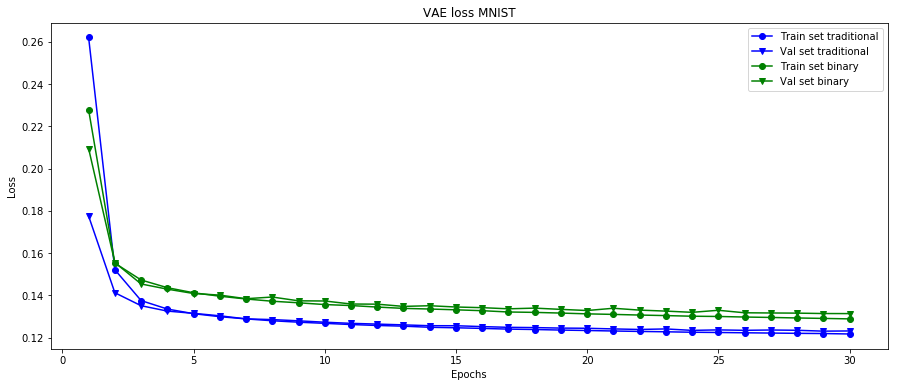

In [14]:
compare_hist_train(hist1,hist2, name_dat)

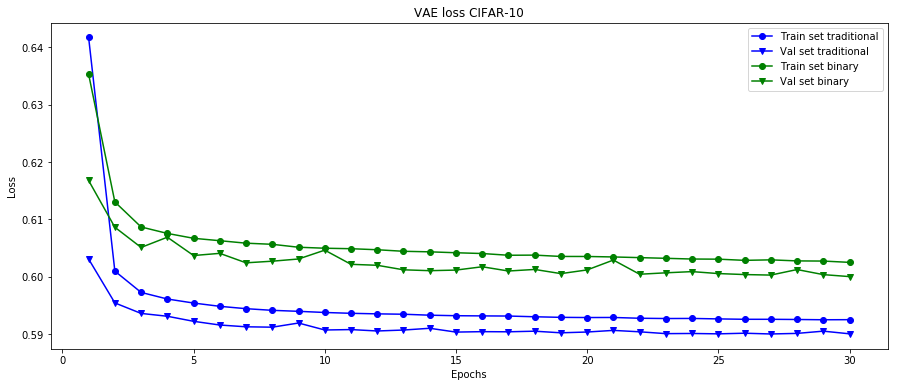

In [43]:
compare_hist_train(hist1,hist2, name_dat)

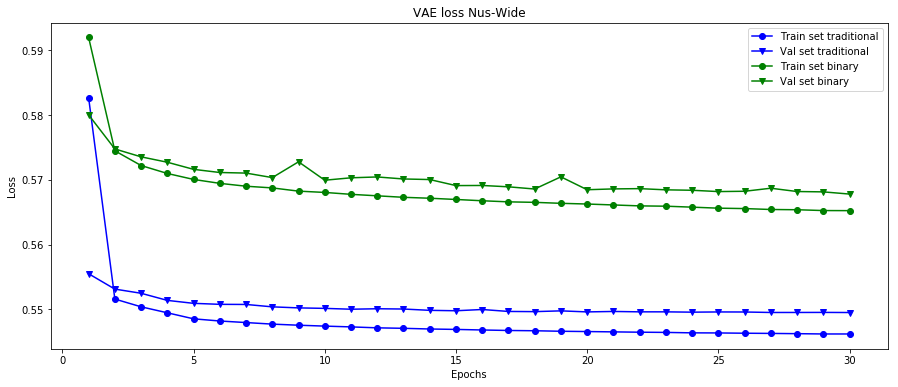

In [18]:
compare_hist_train(hist1,hist2, name_dat) #--64 dim

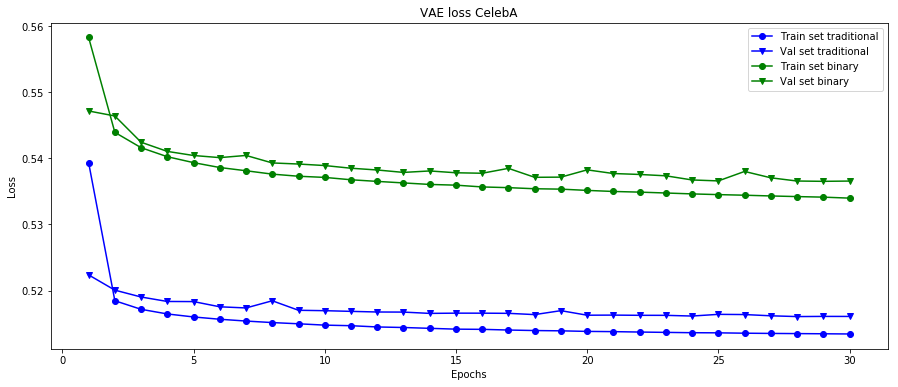

In [15]:
compare_hist_train(hist1,hist2, name_dat) #--64 dim

In [24]:
def show_reconstruct(X, model, low_error=False):
    n = 10
    
    X_hat = model.predict(X)
    idxs = np.arange(len(X))
    if low_error:
        error = np.mean(-X*np.log(X_hat) -(1-X)*np.log(1-X_hat), axis=(1,2,3))
        #values = np.argsort(error)[:n]
        #print(np.sort(error)[:n])
    

    if low_error:
        v = np.mean(error) - 2*np.std(error)
        n_sampleds = np.random.choice( idxs[error < v], size=n, replace=False)
    else:
        n_sampleds = np.random.choice( idxs, size=n, replace=False)
            
    plt.figure(figsize=(20, 4))
    for i,n_i in enumerate(n_sampleds):
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(np.squeeze(X[n_i]))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        plt.title("Imagenes reales")

        ax = plt.subplot(2, n, i + 1 + n)
        plt.imshow(np.squeeze(X_hat[n_i]))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        plt.title("Reconstruccion")
    plt.show()

#### CIFAR

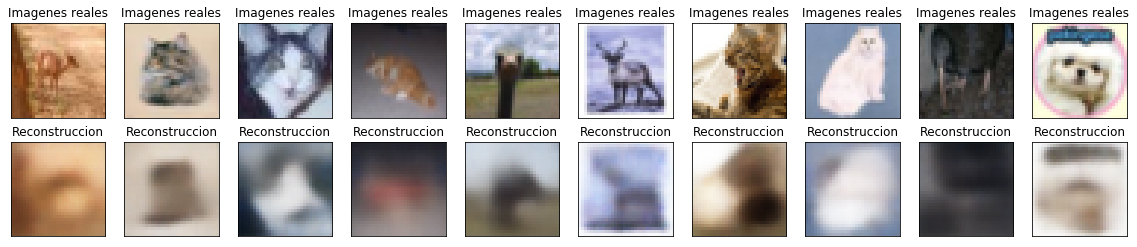

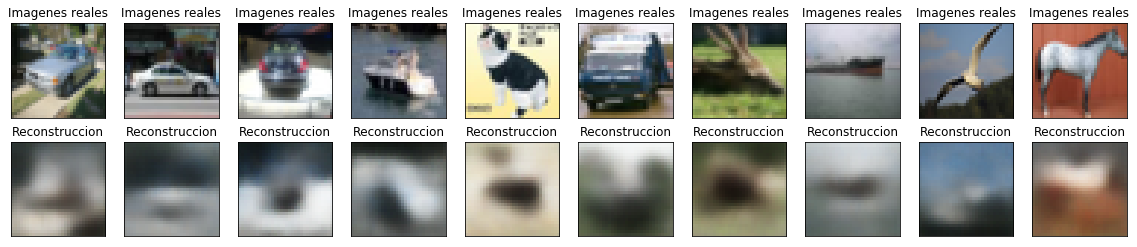

In [44]:
show_reconstruct(X_test, traditional_vae)

show_reconstruct(X_test, binary_vae)

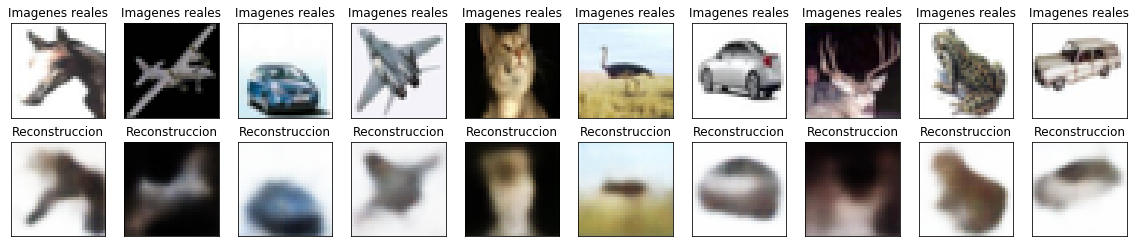

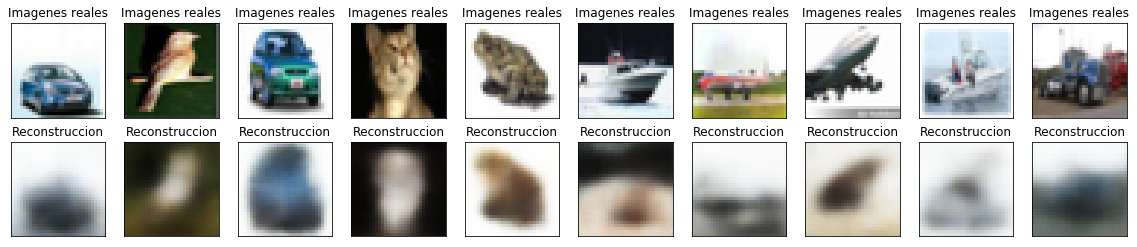

In [45]:
## show low error-images
show_reconstruct(X_test, traditional_vae, low_error=True)

show_reconstruct(X_test, binary_vae, low_error=True)

#### CELEBA

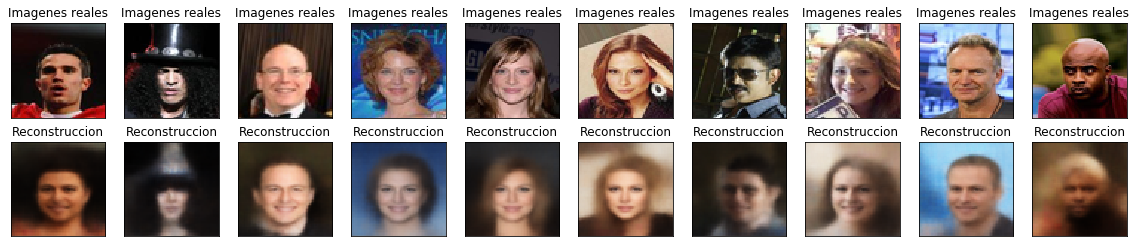

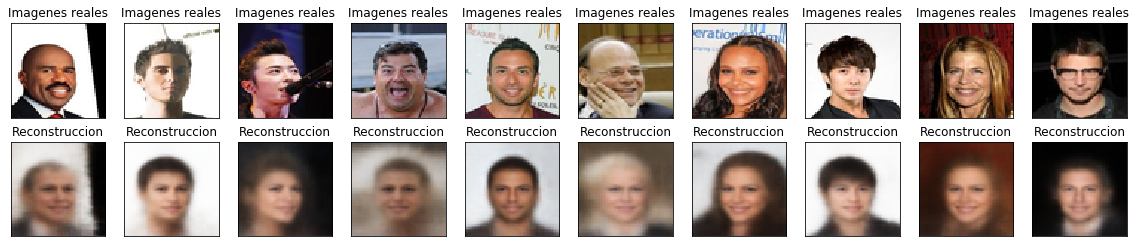

In [17]:
show_reconstruct(X_test, traditional_vae)

show_reconstruct(X_test, binary_vae)

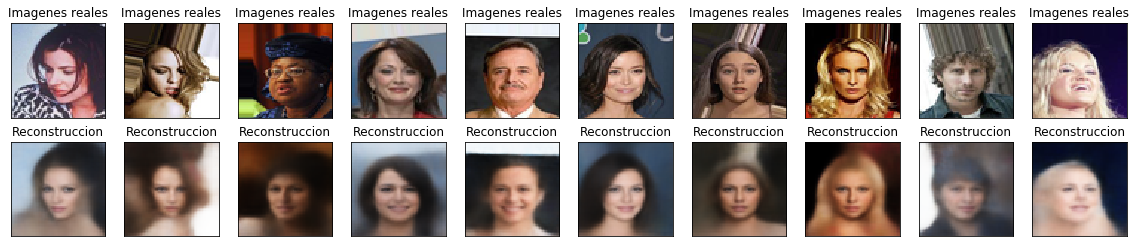

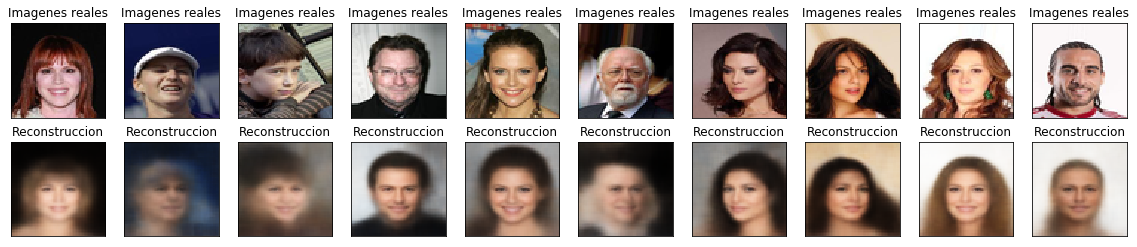

In [25]:
## kernel de 5 
show_reconstruct(X_test, traditional_vae)

show_reconstruct(X_test, binary_vae)

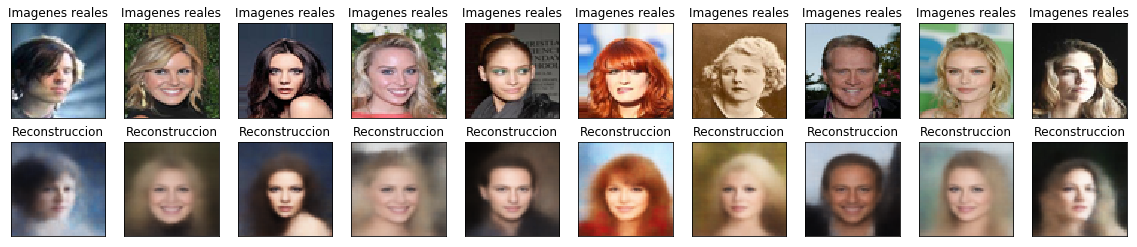

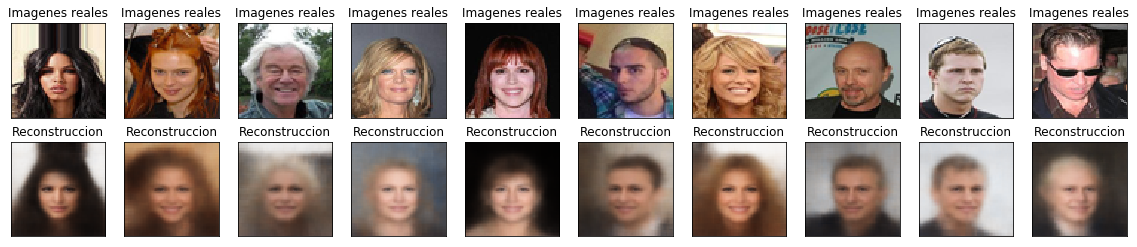

In [33]:
## units 64
show_reconstruct(X_test, traditional_vae)

show_reconstruct(X_test, binary_vae)

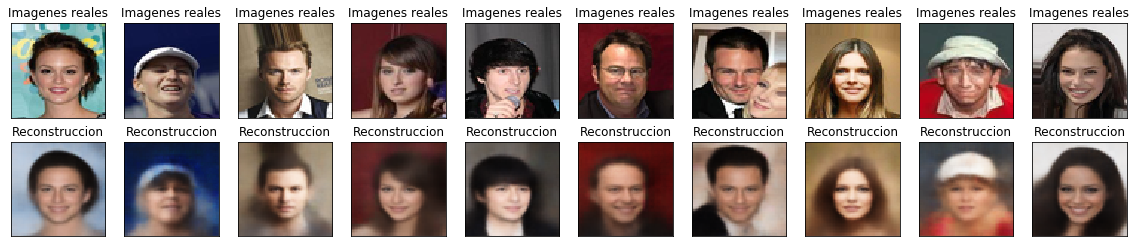

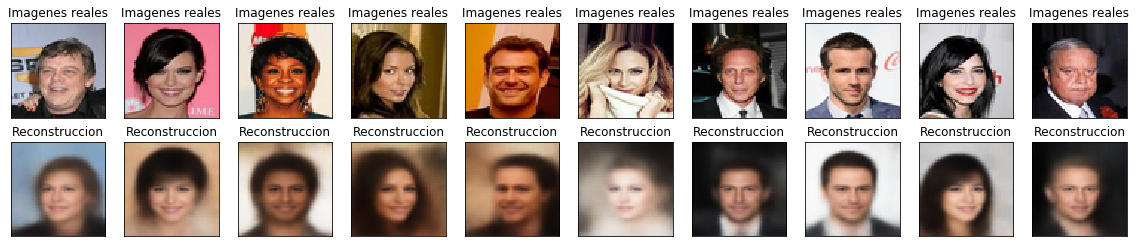

In [40]:
## dense
show_reconstruct(X_test, traditional_vae)

show_reconstruct(X_test, binary_vae)

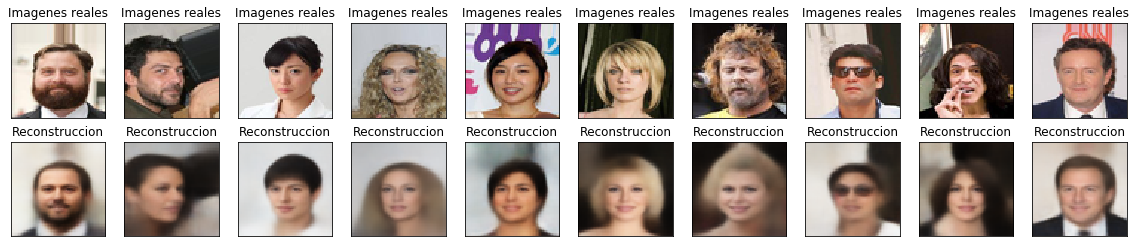

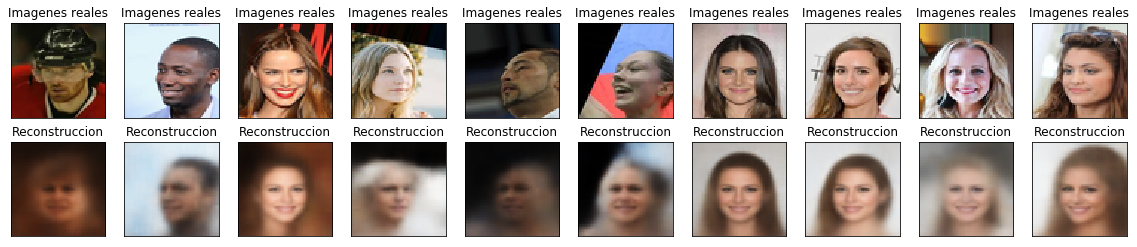

In [47]:
## 5 y 4 capas
show_reconstruct(X_test, traditional_vae)

show_reconstruct(X_test, binary_vae)

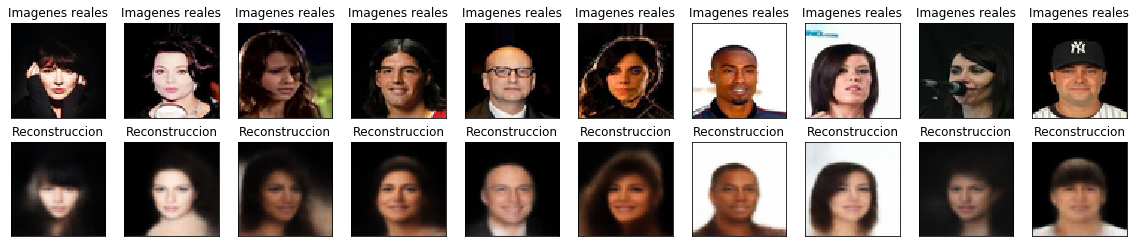

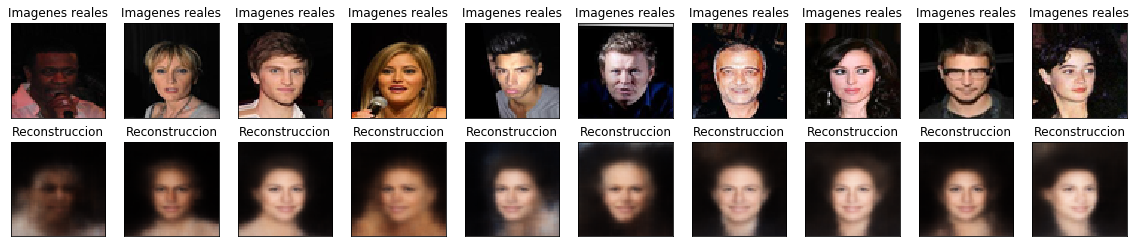

In [54]:
## show low error-images
show_reconstruct(X_test, traditional_vae, low_error=True)

show_reconstruct(X_test, binary_vae, low_error=True)

#### NUSWIDE

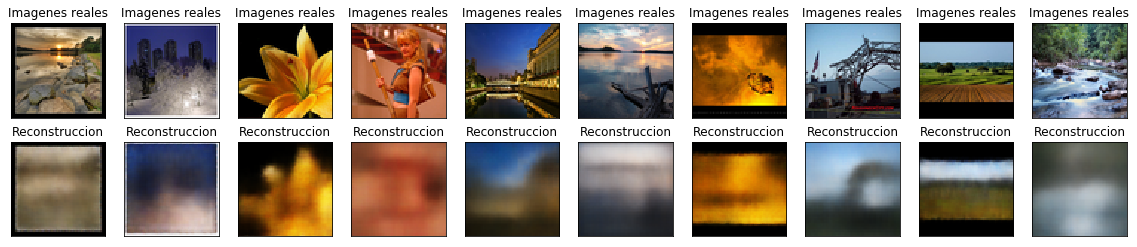

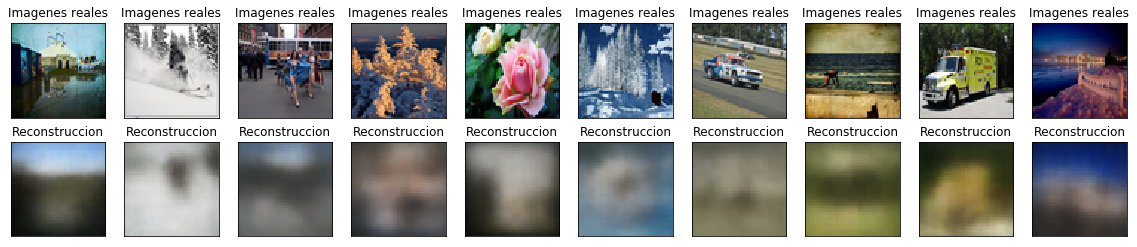

In [20]:
show_reconstruct(X_test, traditional_vae)

show_reconstruct(X_test, binary_vae)

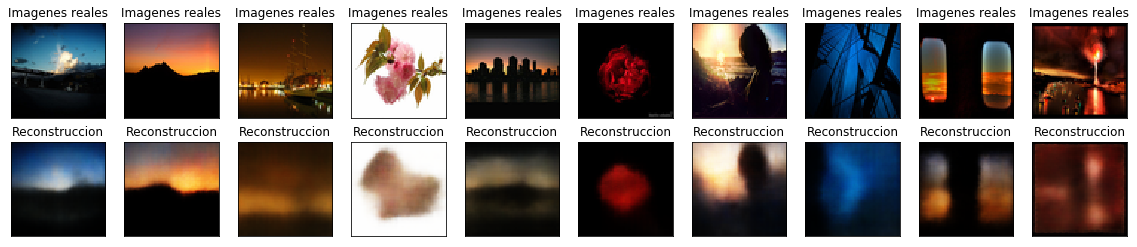

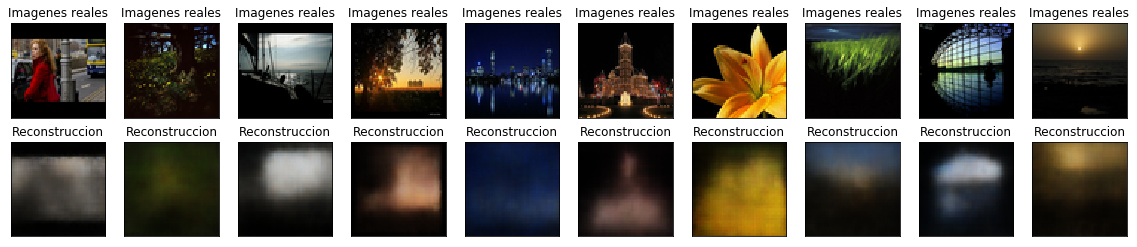

In [21]:
## show low error-images
show_reconstruct(X_test, traditional_vae, low_error=True)

show_reconstruct(X_test, binary_vae, low_error=True)

### Another intrinsic measure: *Classification*


In [36]:
from utils import define_fit

from sklearn.metrics import jaccard_score

results = []
results_B = []

In [37]:
#codify input data (binarize -- or aprox)
X_train_Bcode = expit(encoder_Bvae.predict(X_train))
#X_val_Bcode = expit(encoder_Bvae.predict(X_val))
X_val_Bcode = expit(encoder_Bvae.predict(X_test))

X_train_Tcode = encoder_Tvae.predict(X_train)
#X_val_Tcode = encoder_Tvae.predict(X_val)
X_val_Tcode = encoder_Tvae.predict(X_test)

##codify labels
labels_aux = np.asarray(labels)
def codify_labels(inputs):
    inputs = np.asarray(inputs)
    matrix_labels = np.zeros((inputs.shape[0],labels_aux.shape[0]))
    for i,aux_labels in enumerate(inputs):
        if type(aux_labels) == list or type(aux_labels) == np.ndarray :
            for aux_label in aux_labels:
                idx = np.where(aux_label==labels_aux)[0]
                matrix_labels[i,idx] = 1 #various-multiple
        else:
            idx = np.where(aux_labels==labels_aux)[0]
            matrix_labels[i,idx] = 1 #only one
    return matrix_labels

C_train = codify_labels(labels_train)
#C_val = codify_labels(labels_val)
C_val = codify_labels(labels_test)
C_train

array([[0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [1., 1., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.]])

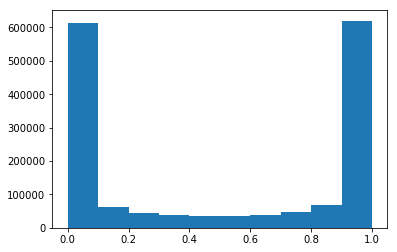

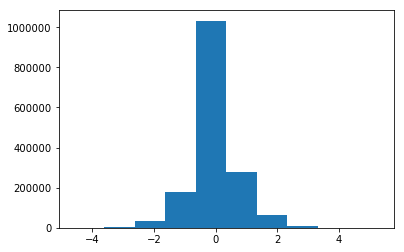

In [18]:
plt.hist(X_train_Bcode.flatten())
plt.show()

plt.hist(X_train_Tcode.flatten())
plt.show()

In [38]:
aux = [name_dat.lower()]
multi_label = "celeba" in aux or "nus-wide" in aux

model1 = define_fit(multi_label,X_train_Bcode,C_train)
model2 = define_fit(multi_label,X_train_Tcode,C_train)

if not multi_label:
    aux.append(model2.evaluate(X_train_Tcode,C_train,verbose=0)[1])
    aux.append(model2.evaluate(X_val_Tcode,C_val,verbose=0)[1])

    aux.append(model1.evaluate(X_train_Bcode,C_train,verbose=0)[1])
    aux.append(model1.evaluate(X_val_Bcode,C_val,verbose=0)[1])
else:
    aux.append(jaccard_score(C_train, (model2.predict(X_train_Tcode)>=0.5)*1, average='micro'))
    aux.append(jaccard_score(C_val, (model2.predict(X_val_Tcode)>=0.5)*1, average='micro'))

    aux.append(jaccard_score(C_train, (model1.predict(X_train_Bcode)>=0.5)*1, average='micro'))
    aux.append(jaccard_score(C_val, (model1.predict(X_val_Bcode)>=0.5)*1, average='micro'))
    
results.append(aux)
print("Done")

Done


In [48]:
for valores in results:
    print("\nAccuracy on dataset: ",valores[0])
    print("Traditional VAE (train-val): %f - %f"%(valores[1],valores[2]))
    print("Binary VAE (train-val): %f - %f"%(valores[3],valores[4]))


Accuracy on dataset:  mnist
Traditional VAE (train-val): 0.998118 - 0.992000
Binary VAE (train-val): 0.982309 - 0.966000

Accuracy on dataset:  cifar-10
Traditional VAE (train-val): 0.567293 - 0.526000
Binary VAE (train-val): 0.478655 - 0.455000


In [26]:
for valores in results:
    print("\nAccuracy on dataset: ",valores[0])
    print("Traditional VAE (train-val): %f - %f"%(valores[1],valores[2]))
    print("Binary VAE (train-val): %f - %f"%(valores[3],valores[4]))


Accuracy on dataset:  nus-wide
Traditional VAE (train-val): 0.294924 - 0.281062
Binary VAE (train-val): 0.240644 - 0.223478


In [21]:
for valores in results:
    print("\nAccuracy on dataset: ",valores[0])
    print("Traditional VAE (train-val): %f - %f"%(valores[1],valores[2]))
    print("Binary VAE (train-val): %f - %f"%(valores[3],valores[4]))


Accuracy on dataset:  celeba
Traditional VAE (train-val): 0.478569 - 0.472048
Binary VAE (train-val): 0.415721 - 0.407369


In [39]:
for valores in results:
    print("\nAccuracy on dataset: ",valores[0])
    print("Traditional VAE (train-val): %f - %f"%(valores[1],valores[2]))
    print("Binary VAE (train-val): %f - %f"%(valores[3],valores[4]))


Accuracy on dataset:  nus-wide
Traditional VAE (train-val): 0.288937 - 0.285243
Binary VAE (train-val): 0.257510 - 0.255154


In [40]:
#Transform to binary
from utils import MedianHashing

median= MedianHashing()
median.fit(X_train_Tcode)

X_train_Tcode_B = median.transform(X_train_Tcode)
X_val_Tcode_B = median.transform(X_val_Tcode)

X_train_Bcode_B = (X_train_Bcode>0.5)*1
X_val_Bcode_B = (X_val_Bcode>0.5)*1

X_train_Tcode_B

array([[1, 0, 1, ..., 1, 0, 1],
       [0, 1, 0, ..., 1, 0, 1],
       [1, 1, 1, ..., 0, 0, 1],
       ...,
       [0, 1, 0, ..., 0, 0, 1],
       [1, 0, 1, ..., 1, 0, 0],
       [0, 1, 1, ..., 1, 0, 1]], dtype=int32)

In [41]:
aux = [name_dat.lower()]
multi_label = "celeba" in aux or "nus-wide" in aux

model1 = define_fit(multi_label,X_train_Bcode_B,C_train)
model2 = define_fit(multi_label,X_train_Tcode_B,C_train)

if not multi_label:
    aux.append(model2.evaluate(X_train_Tcode_B,C_train,verbose=0)[1])
    aux.append(model2.evaluate(X_val_Tcode_B,C_val,verbose=0)[1])

    aux.append(model1.evaluate(X_train_Bcode_B,C_train,verbose=0)[1])
    aux.append(model1.evaluate(X_val_Bcode_B,C_val,verbose=0)[1])
else:
    aux.append(jaccard_score(C_train, (model2.predict(X_train_Tcode_B)>=0.5)*1, average='micro')) 
    aux.append(jaccard_score(C_val, (model2.predict(X_val_Tcode_B)>=0.5)*1, average='micro'))

    aux.append(jaccard_score(C_train, (model1.predict(X_train_Bcode_B)>=0.5)*1, average='micro'))
    aux.append(jaccard_score(C_val, (model1.predict(X_val_Bcode_B)>=0.5)*1, average='micro'))
    
results_B.append(aux)
print("Done")

Done


In [51]:
print("Classification on Binary representation")
for valores in results_B:
    print("\nAccuracy on dataset: ",valores[0])
    print("Traditional VAE (train-val): %f - %f"%(valores[1],valores[2]))
    print("Binary VAE (train-val): %f - %f"%(valores[3],valores[4]))

Classification on Binary representation

Accuracy on dataset:  mnist
Traditional VAE (train-val): 0.880118 - 0.854000
Binary VAE (train-val): 0.963926 - 0.933000

Accuracy on dataset:  cifar-10
Traditional VAE (train-val): 0.412724 - 0.373000
Binary VAE (train-val): 0.446103 - 0.411000


In [29]:
print("Classification on Binary representation")
for valores in results_B:
    print("\nAccuracy on dataset: ",valores[0])
    print("Traditional VAE (train-val): %f - %f"%(valores[1],valores[2]))
    print("Binary VAE (train-val): %f - %f"%(valores[3],valores[4]))

Classification on Binary representation

Accuracy on dataset:  nus-wide
Traditional VAE (train-val): 0.188149 - 0.183570
Binary VAE (train-val): 0.219920 - 0.203699


In [24]:
print("Classification on Binary representation")
for valores in results_B:
    print("\nAccuracy on dataset: ",valores[0])
    print("Traditional VAE (train-val): %f - %f"%(valores[1],valores[2]))
    print("Binary VAE (train-val): %f - %f"%(valores[3],valores[4]))

Classification on Binary representation

Accuracy on dataset:  celeba
Traditional VAE (train-val): 0.413136 - 0.406326
Binary VAE (train-val): 0.395382 - 0.387473


In [42]:
print("Classification on Binary representation")
for valores in results_B:
    print("\nAccuracy on dataset: ",valores[0])
    print("Traditional VAE (train-val): %f - %f"%(valores[1],valores[2]))
    print("Binary VAE (train-val): %f - %f"%(valores[3],valores[4]))

Classification on Binary representation

Accuracy on dataset:  nus-wide
Traditional VAE (train-val): 0.202314 - 0.196297
Binary VAE (train-val): 0.216182 - 0.212249


A través de las curvas de entrenamiento se puede ver que el VAE tradicional obtiene mejores resultados que el binario respecto a la reconstrucción de los datos, lo cual resulta bastante lógico ya que tiene valores más libres en donde pueden vivir las variables (dominio de variable latente: los reales) *vs* el binario que está mucho más restringido (dominio de variable latente: entre 0 y 1). Otra cosa a nombrar es que el modelo con variables latentes binarias reduce el *overfitting* drásticamente, disminuyendo ambas curvas en la misma proporción.

### Results
---
Para evaluar los resultados y poder comparar es necesario realizar el proceso de evaluación en un sistema de recuperación de información. Ésto es recuperar objetos similares a los objetos de una consulta/*query*. Como *baseline* para comparar se utiliza el modelo presentado en *Variational Deep Semantic Hashing* (VDSH).

#### Proceso de evaluación (*content-based retrieval*)
> *Query*: **Documento**

1. Calcular código hashing/binario de cada dato/documento
    * Para *VAE* tradicional se utiliza la mediana de cada componente como *treshold*
    * Para *VAE* binario se utiliza el *treshold* de 0.5 en la probabilidad
2. Recuperar documentos basado en *match* perfecto, *top K* o *ball search* de distancia *hamming* de un documento consulta.
    * En el mismo conjunto/*set*
    * Con *query* recupero sobre *database*
3. Medir *precision* y *recall* en base a algún criterio de relevancia.
    * Documento relevante a otro o no -> Si comparten al menos una clase.
    
|$b_1$|$b_2$|$b_3$|$b_4$|
|---|---|---|---|
||..|..||
|1|0|1|0| 
|1|0|1|1| 
|1|0|0|0| 
|1|0|0|1|
||..|..||

In [15]:
from utils import MedianHashing, get_similar, measure_metrics
from utils import MAP_atk, M_P_atk, AP_atk

In [14]:
#load vae, encoder and generator
encode_train = encoder_Tvae.predict(X_train)
encode_val = encoder_Tvae.predict(X_val)

#para VAE tradicional
median= MedianHashing()
median.fit(encode_train)

train_hash = median.transform(encode_train)
val_hash = median.transform(encode_val)
del encode_train, encode_val
gc.collect()
train_hash

array([[0, 1, 0, ..., 1, 0, 0],
       [1, 0, 0, ..., 1, 0, 1],
       [0, 1, 0, ..., 1, 0, 0],
       ...,
       [1, 0, 1, ..., 0, 1, 0],
       [0, 1, 0, ..., 1, 0, 0],
       [1, 1, 1, ..., 1, 0, 1]])

In [16]:
encode_train = encoder_Bvae.predict(X_train) #logits
encode_val = encoder_Bvae.predict(X_val)

#para Binary VAE
probas_train = expit(encode_train)
probas_val = expit(encode_val)
del encode_train, encode_val
gc.collect()

train_hash = (probas_train > 0.5)*1
val_hash = (probas_val > 0.5)*1
train_hash

array([[1, 1, 0, ..., 0, 1, 1],
       [1, 0, 0, ..., 0, 1, 1],
       [1, 1, 0, ..., 0, 1, 1],
       ...,
       [1, 1, 0, ..., 0, 1, 1],
       [1, 1, 0, ..., 0, 1, 0],
       [1, 1, 1, ..., 0, 1, 1]])

In [15]:
val_similares_val =  get_similar(val_hash,train_hash,tipo="EM")
val_similares_val[:2]

[array([], dtype=int64), array([], dtype=int64)]

En algunos casos cuando se busca con un *match* exacto no se encuentra ningún otro dato que se le asigne la misma dirección, es por ésto que se acude a otras técnicas para buscar objetos similares.

In [17]:
%%time
val_similares_train =  get_similar(val_hash, train_hash,tipo="topK",K=100)
val_similares_train[:2]

CPU times: user 2min 41s, sys: 314 ms, total: 2min 42s
Wall time: 2min 41s


In [18]:
%%time
precision,recall = measure_metrics(labels, val_similares_train, labels_query=labels_val, labels_source=labels_train)
print("Precision (query: validation, source: validation) ",precision)
print("Recall    (query: validation, source: validation) ",recall)

Precision (query: validation, source: validation)  0.9699783560678049
Recall    (query: validation, source: validation)  0.00019451307460520553
CPU times: user 3.66 s, sys: 8.61 ms, total: 3.67 s
Wall time: 3.65 s


In [19]:
%%time
v= M_P_atk(val_similares_train, labels_query=labels_val, labels_source=labels_train, K=100)
print("Mean Precision at K(query: validation, source: validation) ",v)

Mean Precision at K(query: validation, source: validation)  0.9699783560678513
CPU times: user 2.51 s, sys: 5.63 ms, total: 2.52 s
Wall time: 2.5 s


In [61]:
%%time
v = MAP_atk(val_similares_train, labels_query=labels_val, labels_source=labels_train, K=0)
print("MAP at K(query: validation, source: validation) ",v)

MAP at K(query: validation, source: validation)  0.9714528113603165
CPU times: user 1min 54s, sys: 132 ms, total: 1min 54s
Wall time: 1min 53s


### Experimentación
---
A continación se realizan las experimentaciones correspondientes para encontrar la mejor arquitectura y mejor configuración del modelo propuesto en base a las métricas *precision* y *recall* del conjunto de validación en el **top 100** de elementos recuperados.

In [16]:
def evaluate_hashing(encoder,train,val,labels_train,labels_val,traditional=True,tipo="topK", MAP=False,K=100):
    encode_train = encoder.predict(train)
    encode_val = encoder.predict(val)
    if traditional:
        median= MedianHashing()
        median.fit(encode_train)
        val_train = median.transform(encode_train)
        val_hash = median.transform(encode_val)
        del encode_train, encode_val
        gc.collect()
    else: #para Binary VAE
        probas_train = expit(encode_train)
        probas_val = expit(encode_val)
        del encode_train, encode_val
        gc.collect()
        val_train = (probas_train > 0.5)*1
        val_hash = (probas_val > 0.5)*1

    val_similares_train =  get_similar(val_hash, val_train, tipo=tipo,K=K) 
    
    if MAP:
        return MAP_atk(val_similares_train,labels_query=labels_val,labels_source=labels_train, K=0) #all ranking
    else:
        return measure_metrics(labels,val_similares_train,labels_query=labels_val,labels_source=labels_train)


### Experimentando variando el #Bits

In [45]:
traditional_dat = {"mnist":{"p":[],"r":[]},"cifar-10":{"p":[],"r":[]},"celeba":{"p":[],"r":[]},'nus-wide':{"p":[],"r":[]}}
binary_dat = {"mnist":{"p":[],"r":[]},"cifar-10":{"p":[],"r":[]},"celeba":{"p":[],"r":[]},'nus-wide':{"p":[],"r":[]}}

In [46]:
Nbits = np.asarray([4,8,16,32,64])
dataset = name_dat.lower()

for Nbit in Nbits:
    traditional_vae, encoder_Tvae, generator_Tvae = define_traditional_VAE(aux_pre_E, aux_G, Nb=Nbit)
    traditional_vae.fit(X_train, X_train, epochs=epochs, batch_size=batch_size,verbose=0)
    p_t,r_t = evaluate_hashing(encoder_Tvae,X_train,X_val,labels_train,labels_val,traditional=True,tipo="topK")
    traditional_dat[dataset]["p"].append(p_t) 
    traditional_dat[dataset]["r"].append(r_t) 
    del traditional_vae, encoder_Tvae, generator_Tvae
    keras.backend.clear_session()
    gc.collect()
    
    binary_vae, encoder_Bvae, generator_Bvae = define_binary_VAE(aux_pre_E, aux_G, Nb=Nbit)
    binary_vae.fit(X_train, X_train, epochs=epochs, batch_size=batch_size,verbose=0)
    p_b,r_b = evaluate_hashing(encoder_Bvae,X_train,X_val,labels_train,labels_val,traditional=False,tipo="topK")
    binary_dat[dataset]["p"].append(p_b) 
    binary_dat[dataset]["r"].append(r_b) 
    del binary_vae, encoder_Bvae, generator_Bvae
    keras.backend.clear_session()
    gc.collect()

pre-encoder network:
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 64, 64, 3)         0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
batch_normalization_1 (Batch (None, 32, 32, 32)        128       
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 16, 16, 64)        18496     
_________________________________________________________________
batch_normalization_2 (Batch (None, 16, 16, 64)        256       
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 8, 8, 128)         73856     
_________________________________________________________________
batch_normalization_3 (Batch (None, 8, 8, 128)         

In [53]:
print("Resultados de Precision en validación")
t = Table()
t["N bits"] = Nbits
t["MNIST"] = traditional_dat["mnist"]["p"]
t["CIFAR-10"] = traditional_dat["cifar-10"]["p"]
print("\n*** VAE Traditional***")
print(t)
t = Table()
t["N bits"] = Nbits
t["MNIST"] = binary_dat["mnist"]["p"]
t["CIFAR-10"] = binary_dat["cifar-10"]["p"]
print("\n*** VAE Binary***")
print(t)

print("\nResultados de Recall en validación")
t = Table()
t["N bits"] = Nbits
t["MNIST"] = traditional_dat["mnist"]["r"]
t["CIFAR-10"] = traditional_dat["cifar-10"]["r"]
print("\n*** VAE Traditional***")
print(t)
t = Table()
t["N bits"] = Nbits
t["MNIST"] = binary_dat["mnist"]["r"]
t["CIFAR-10"] = binary_dat["cifar-10"]["r"]
print("\n*** VAE Binary***")
print(t)

Resultados de Precision en validación

*** VAE Traditional***
N bits        MNIST              CIFAR-10     
------ ------------------- -------------------
     4 0.40401999999999993 0.13822000000000031
     8  0.5618899999999996 0.17268000000000036
    16  0.5685599999999996  0.1761099999999999
    32  0.6035600000000009 0.17923999999999995
    64  0.6941500000000008  0.1825699999999995

*** VAE Binary***
N bits        MNIST              CIFAR-10     
------ ------------------- -------------------
     4 0.48005999999999927 0.13687999999999978
     8  0.8125300000000036  0.1917200000000001
    16  0.7599600000000013 0.20724999999999968
    32  0.7900900000000018  0.2263300000000001
    64  0.7560000000000018  0.2454000000000002

Resultados de Recall en validación

*** VAE Traditional***
N bits        MNIST                CIFAR-10      
------ -------------------- ---------------------
     4 0.005884883965718449 0.0023833007930004384
     8 0.008273409574242005 0.0029775332895549487
 

In [34]:
print("Resultados de Precision en validación")
t = Table()
t["N bits"] = Nbits
t["Nus-Wide"] = traditional_dat["nus-wide"]["p"]

print("\n*** VAE Traditional***")
print(t)
t = Table()
t["N bits"] = Nbits
t["Nus-Wide"] = binary_dat["nus-wide"]["p"]

print("\n*** VAE Binary***")
print(t)

print("\nResultados de Recall en validación")
t = Table()
t["N bits"] = Nbits
t["Nus-Wide"] = traditional_dat["nus-wide"]["r"]

print("\n*** VAE Traditional***")
print(t)
t = Table()
t["N bits"] = Nbits
t["Nus-Wide"] = binary_dat["nus-wide"]["r"]

print("\n*** VAE Binary***")
print(t)

Resultados de Precision en validación

*** VAE Traditional***
N bits       Nus-Wide     
------ -------------------
     4  0.3588714285714296
     8  0.3827619047619041
    16  0.4017619047619052
    32 0.41665714285714234
    64  0.3997476190476177

*** VAE Binary***
N bits      Nus-Wide     
------ ------------------
     4 0.3563095238095228
     8 0.3845095238095242
    16 0.4053904761904761
    32 0.4264904761904763
    64 0.4404761904761905

Resultados de Recall en validación

*** VAE Traditional***
N bits        Nus-Wide      
------ ---------------------
     4 0.0006384554410876936
     8 0.0006902741841617726
    16 0.0007288096496407743
    32 0.0007735387142243964
    64 0.0007353330550672241

*** VAE Binary***
N bits        Nus-Wide      
------ ---------------------
     4 0.0006510900845395609
     8 0.0006997215940712933
    16 0.0007466215324241926
    32 0.0008059847124791999
    64 0.0008241530181271584


In [67]:
print("Resultados de Precision en validación")
t = Table()
t["N bits"] = Nbits
t["CelebA"] = traditional_dat["celeba"]["p"]

print("\n*** VAE Traditional***")
print(t)
t = Table()
t["N bits"] = Nbits
t["CelebA"] = binary_dat["celeba"]["p"]

print("\n*** VAE Binary***")
print(t)

print("\nResultados de Recall en validación")
t = Table()
t["N bits"] = Nbits
t["CelebA"] = traditional_dat["celeba"]["r"]

print("\n*** VAE Traditional***")
print(t)
t = Table()
t["N bits"] = Nbits
t["CelebA"] = binary_dat["celeba"]["r"]

print("\n*** VAE Binary***")
print(t)

Resultados de Precision en validación

*** VAE Traditional***
N bits       CelebA      
------ ------------------
     4 0.9689716615492421
     8 0.9716509790103814
    16 0.9748633412190665
    32 0.9776720189258216
    64 0.9776453415210752

*** VAE Binary***
N bits       CelebA      
------ ------------------
     4 0.9655131625307836
     8 0.9710379020485713
    16 0.9743131826646825
    32 0.9774560829515906
    64 0.9799295313836744

Resultados de Recall en validación

*** VAE Traditional***
N bits         CelebA        
------ ----------------------
     4 0.00019419679295489716
     8 0.00019547170438290342
    16 0.00019635708877891676
    32  0.0001973191962131159
    64 0.00019726022729470543

*** VAE Binary***
N bits         CelebA        
------ ----------------------
     4 0.00019353991416204883
     8 0.00019525253163009979
    16 0.00019627569403752384
    32 0.00019720803609917303
    64 0.00019801526239171348


In [47]:
print("Resultados de Precision en validación")
t = Table()
t["N bits"] = Nbits
t["Nus-Wide"] = traditional_dat["nus-wide"]["p"]

print("\n*** VAE Traditional***")
print(t)
t = Table()
t["N bits"] = Nbits
t["Nus-Wide"] = binary_dat["nus-wide"]["p"]

print("\n*** VAE Binary***")
print(t)

print("\nResultados de Recall en validación")
t = Table()
t["N bits"] = Nbits
t["Nus-Wide"] = traditional_dat["nus-wide"]["r"]

print("\n*** VAE Traditional***")
print(t)
t = Table()
t["N bits"] = Nbits
t["Nus-Wide"] = binary_dat["nus-wide"]["r"]

print("\n*** VAE Binary***")
print(t)

Resultados de Precision en validación

*** VAE Traditional***
N bits       Nus-Wide     
------ -------------------
     4  0.3594340000000069
     8 0.38138499999999964
    16 0.40095900000000106
    32  0.3980320000000016
    64 0.39200600000000146

*** VAE Binary***
N bits       Nus-Wide     
------ -------------------
     4  0.3577820000000025
     8  0.3847500000000001
    16  0.4110800000000003
    32  0.4245610000000005
    64 0.43870800000000026

Resultados de Recall en validación

*** VAE Traditional***
N bits        Nus-Wide      
------ ---------------------
     4  0.000702082224191185
     8 0.0007652328727196433
    16 0.0008124207064414648
    32  0.000805940177657914
    64 0.0007840501890566881

*** VAE Binary***
N bits        Nus-Wide      
------ ---------------------
     4 0.0007210518091668402
     8  0.000773525037701812
    16  0.000843477002134564
    32 0.0008830915472243888
    64 0.0009061257948487954


## *Best models facing test set*
Luego de la selección de la mejor configuración de los modelos se evalua de diferentes formas sobre el conjunto de pruebas de los distintos *datasets*, los cambios realizados son:
* Se entrenan sobre todos los datos disponibles (*train+val*)
* Se aumentó el número de *epochs* a 50.

El mejor modelo:
* Simétrica para *Binary VAE* y Base para *Traditional VAE*
* 32 Bits en la codificación (número de variables latentes)
* Representación sobre las top 10 mil *tokens* más frecuentes y *Term Frequency*

In [17]:
BITS_S = 32

In [18]:
X_total = np.concatenate((X_train,X_val),axis=0)
labels_total = np.concatenate((labels_train,labels_val),axis=0)
del X_train, X_val, labels_train,labels_val
gc.collect()

453

In [19]:
traditional_vae, encoder_Tvae, generator_Tvae = define_traditional_VAE(aux_pre_E, aux_G, Nb=BITS_S)
traditional_vae.fit(X_total, X_total, epochs=50, batch_size=batch_size,verbose=0)
#save model
encoder_Tvae.save("saved_models/"+name_dat+"_VAE_"+str(BITS_S)+"b_E_defaultCNN_v2.h5")
###generator_Tvae.save("saved_models/"+name_dat+"_VAE_"+str(BITS_S)+"b_D_defaultCNN.h5") #it is not used


binary_vae, encoder_Bvae, generator_Bvae = define_binary_VAE(aux_pre_E, aux_G, Nb=BITS_S)
binary_vae.fit(X_total, X_total, epochs=50, batch_size=batch_size,verbose=0)
#save model
encoder_Bvae.save("saved_models/"+name_dat+"_BVAE_"+str(BITS_S)+"b_E_defaultCNN_v2.h5")
generator_Bvae.save_weights("saved_models/"+name_dat+"_BVAE_"+str(BITS_S)+"b_D_defaultCNN_w_v2.h5")

keras.backend.clear_session()
gc.collect()

pre-encoder network:
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 64, 64, 3)         0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
batch_normalization_1 (Batch (None, 32, 32, 32)        128       
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 16, 16, 64)        18496     
_________________________________________________________________
batch_normalization_2 (Batch (None, 16, 16, 64)        256       
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 8, 8, 128)         73856     
_________________________________________________________________
batch_normalization_3 (Batch (None, 8, 8, 128)         

158

In [20]:
def evaluate_hashing(train_hash,test_hash,labels_trainn,labels_testt,tipo="topK",eval_tipo='PRatk',K=100):
    """
        Evaluate Hashing correclty: Query and retrieve on a different set
    """
    test_similares_train =  get_similar(test_hash,train_hash,tipo=tipo,K=K)
    if eval_tipo=="MAP":
        return MAP_atk(test_similares_train,labels_query=labels_testt, labels_source=labels_trainn, K=0) #all ranking
    elif eval_tipo == "PRatk":
        return measure_metrics(labels,test_similares_train,labels_testt,labels_source=labels_trainn)
    elif eval_tipo == "Patk":
        return M_P_atk(test_similares_train, labels_query=labels_testt, labels_source=labels_trainn, K=K)

def hash_data(model, x_train, x_test, binary=True):
    encode_train = model.predict(x_train)
    encode_test = model.predict(x_test)
    if binary: #para Binary VAE
        probas_train = expit(encode_train)
        probas_test = expit(encode_test)
        train_hash = (probas_train > 0.5)*1
        test_hash = (probas_test > 0.5)*1
    else:
        median= MedianHashing()
        median.fit(encode_train)
        train_hash = median.transform(encode_train)
        test_hash = median.transform(encode_test)
    return train_hash, test_hash

#to save results
results_dat = {"mnist":{"p":[],"r":[],'p5k':[]},
               "cifar-10":{"p":[],"r":[], 'p5k':[]},
               "celeba":{"p":[],"r":[],'p5k':[]},
              "nus-wide":{"p":[],"r":[],'p5k':[]}} 

BITS_S = 32

In [21]:
##load model
encoder_Tvae = keras.models.load_model("saved_models/"+name_dat+"_VAE_"+str(BITS_S)+"b_E_defaultCNN_v2.h5")
encoder_Bvae = keras.models.load_model("saved_models/"+name_dat+"_BVAE_"+str(BITS_S)+"b_E_defaultCNN_v2.h5")
#generator_Bvae = keras.models.load_model("saved_models/"+name_dat+"_BVAE_"+str(BITS_S)+"b_D_defaultCNN.h5")
encoder_Bvae.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_10 (InputLayer)        (None, 64, 64, 3)         0         
_________________________________________________________________
pre-encoder (Model)          (None, 8192)              94144     
_________________________________________________________________
logits-b (Dense)             (None, 32)                262176    
Total params: 356,320
Trainable params: 355,872
Non-trainable params: 448
_________________________________________________________________


/home/fmena/.local/lib/python3.5/site-packages/keras/models.py:251: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


In [22]:
total_hash_VAE, test_hash_VAE = hash_data(encoder_Tvae,X_total,X_test, binary=False)
total_hash_BVAE, test_hash_BVAE = hash_data(encoder_Bvae,X_total,X_test)

del X_total, X_test
gc.collect()

84

In [22]:
dataset = name_dat.lower()

p_t,r_t = evaluate_hashing(total_hash_VAE,test_hash_VAE,labels_total,labels_test,tipo="topK")
results_dat[dataset]["p"].append(p_t)
results_dat[dataset]["r"].append(r_t)
p5k_t = evaluate_hashing(total_hash_VAE,test_hash_VAE,labels_total,labels_test,eval_tipo="Patk",K=5000)
results_dat[dataset]["p5k"].append(p5k_t)

p_b,r_b = evaluate_hashing(total_hash_BVAE, test_hash_BVAE,labels_total,labels_test,tipo="topK")
results_dat[dataset]["p"].append(p_b)
results_dat[dataset]["r"].append(r_b)
p5k_b = evaluate_hashing(total_hash_BVAE, test_hash_BVAE,labels_total,labels_test,eval_tipo="Patk",K=5000)
results_dat[dataset]["p5k"].append(p5k_b)

print("Realizado.")

Realizado.


In [54]:
print("*************Top 100 most similar retrieve*************")

print("\nResultados de Precision en pruebas")
t = Table()
t["Modelo"] = ["Tradicional","Binario"]
t["MNIST"] = results_dat["mnist"]["p"]
t["CIFAR-10"] = results_dat["cifar-10"]["p"]
#t["CelebA"] = results_dat["celeba"]["p"]
#t["Nus-Wide"] = results_dat["nus-wide"]["p"]
print(t)

print("\n\nResultados de Recall en pruebas")
t = Table()
t["Modelo"] = ["Tradicional","Binario"]
t["MNIST"] = results_dat["mnist"]["r"]
t["CIFAR-10"] = results_dat["cifar-10"]["r"]
#t["CelebA"] = results_dat["celeba"]["r"]
#t["Nus-Wide"] = results_dat["nus-wide"]["r"]
print(t)

print("\n\nResultados de Precision en pruebas (top-5k)")
t = Table()
t["Modelo"] = ["Tradicional","Binario"]
t["MNIST"] = results_dat["mnist"]["p5k"]
t["CIFAR-10"] = results_dat["cifar-10"]["p5k"]
#t["CelebA"] = results_dat["celeba"]["p5k"]
#t["Nus-Wide"] = results_dat["nus-wide"]["p5k"]
print(t)

*************Top 100 most similar retrieve*************

Resultados de Precision en pruebas
   Modelo         MNIST              CIFAR-10     
----------- ------------------ -------------------
Tradicional 0.6156200000000005 0.17588999999999996
    Binario 0.7878400000000013  0.2216700000000003


Resultados de Recall en pruebas
   Modelo          MNIST               CIFAR-10      
----------- -------------------- --------------------
Tradicional 0.008905588368251824 0.002981186440677965
    Binario 0.011411993091407589 0.003757118644067799


Resultados de Precision en pruebas (top-5k)
   Modelo    MNIST    CIFAR-10
----------- -------- ---------
Tradicional 0.278506 0.1277456
    Binario 0.369784  0.149366


In [49]:
print("*************Top 100 most similar retrieve*************")

print("\nResultados de Precision en pruebas")
t = Table()
t["Modelo"] = ["Tradicional","Binario"]
t["CelebA"] = results_dat["celeba"]["p"]
t["Nus-Wide"] = results_dat["nus-wide"]["p"]
print(t)

print("\n\nResultados de Recall en pruebas")
t = Table()
t["Modelo"] = ["Tradicional","Binario"]
t["CelebA"] = results_dat["celeba"]["r"]
t["Nus-Wide"] = results_dat["nus-wide"]["r"]
print(t)

print("\n\nResultados de Precision en pruebas (top-5k)")
t = Table()
t["Modelo"] = ["Tradicional","Binario"]
t["CelebA"] = results_dat["celeba"]["p5k"]
t["Nus-Wide"] = results_dat["nus-wide"]["p5k"]
print(t)

*************Top 100 most similar retrieve*************

Resultados de Precision en pruebas
   Modelo         CelebA            Nus-Wide     
----------- ------------------ ------------------
Tradicional  0.980831580001973 0.4638142857142849
    Binario 0.9803566776875774 0.4970571428571421


Resultados de Recall en pruebas
   Modelo           CelebA                Nus-Wide      
----------- ---------------------- ---------------------
Tradicional 0.00016916625908108439  0.000658525948236799
    Binario 0.00016907759267721208 0.0007416513466426926


Resultados de Precision en pruebas (top-5k)
   Modelo         CelebA            Nus-Wide     
----------- ------------------ ------------------
Tradicional 0.9765136759843702 0.4151192380952381
    Binario 0.9760355174832183 0.4385038095238095


In [23]:
print("*************Top 100 most similar retrieve*************")

print("\nResultados de Precision en pruebas")
t = Table()
t["Modelo"] = ["Tradicional","Binario"]
t["Nus-Wide"] = results_dat["nus-wide"]["p"]
print(t)

print("\n\nResultados de Recall en pruebas")
t = Table()
t["Modelo"] = ["Tradicional","Binario"]
t["Nus-Wide"] = results_dat["nus-wide"]["r"]
print(t)

print("\n\nResultados de Precision en pruebas (top-5k)")
t = Table()
t["Modelo"] = ["Tradicional","Binario"]
t["Nus-Wide"] = results_dat["nus-wide"]["p5k"]
print(t)

*************Top 100 most similar retrieve*************

Resultados de Precision en pruebas
   Modelo        Nus-Wide     
----------- ------------------
Tradicional 0.3974210000000026
    Binario 0.4237460000000009


Resultados de Recall en pruebas
   Modelo          Nus-Wide      
----------- ---------------------
Tradicional 0.0007637930629183341
    Binario    0.0008181640382488


Resultados de Precision en pruebas (top-5k)
   Modelo         Nus-Wide     
----------- -------------------
Tradicional  0.3576329000000001
    Binario 0.37810347999999994


In [19]:
print("MAP on %s dataset"%name_dat)
map_t= evaluate_hashing(total_hash_VAE,test_hash_VAE,labels_total,labels_test,eval_tipo="MAP",K=9999999)
print("Traditional VAE = ",map_t)

map_b= evaluate_hashing(total_hash_BVAE, test_hash_BVAE,labels_total,labels_test,eval_tipo="MAP",K=9999999)
print("Binary VAE = ",map_b)

MAP on CIFAR-10 dataset
Traditional VAE =  0.11502279023035951
Binary VAE =  0.13111404254148443


In [37]:
def MAP_slow_bigD(D_hash, Q_hash, D_labels, Q_labels):
    #+ eficiente en memoria..
    MAP = 0.0
    for query_hash, query_label in zip(Q_hash, Q_labels):
        hamm_rank_idx = get_similar(query_hash, D_hash ,tipo='topK',K=999999999)[0]
        
        MAP += AP_atk(hamm_rank_idx, label_query=query_label, labels_source=D_labels, K=0)

    return MAP/len(Q_hash)

In [38]:
print("MAP on %s dataset"%name_dat)
map_t= MAP_slow_bigD(total_hash_VAE,test_hash_VAE,labels_total,labels_test)
print("Traditional VAE = ",map_t)

map_b= MAP_slow_bigD(total_hash_BVAE, test_hash_BVAE,labels_total,labels_test)
print("Binary VAE = ",map_b)

MAP on Nus-Wide dataset
Traditional VAE =  0.3135930199250578
Binary VAE =  0.31389749516057847


### data with 100 images per class

In [23]:
print("MAP@5000 on %s dataset"%name_dat)
map_t= evaluate_hashing(total_hash_VAE,test_hash_VAE,labels_total,labels_test,eval_tipo="MAP",K=5000)
print("Traditional VAE = ",map_t)

map_b= evaluate_hashing(total_hash_BVAE, test_hash_BVAE,labels_total,labels_test,eval_tipo="MAP",K=5000)
print("Binary VAE = ",map_b)

#mejora ?? (beta cambio)

MAP@5000 on Nus-Wide dataset
Traditional VAE =  0.44479264472657476
Binary VAE =  0.47304450459100367


In [23]:
print("MAP on %s dataset"%name_dat)
map_t= evaluate_hashing(total_hash_VAE,test_hash_VAE,labels_total,labels_test,eval_tipo="MAP",K=9999999)
print("Traditional VAE = ",map_t)

map_b= evaluate_hashing(total_hash_BVAE, test_hash_BVAE,labels_total,labels_test,eval_tipo="MAP",K=9999999)
print("Binary VAE = ",map_b)

MAP on Nus-Wide dataset
Traditional VAE =  0.3853880172067205
Binary VAE =  0.39692654113429615


In [20]:
print("MAP on %s dataset"%name_dat)
map_t= evaluate_hashing(total_hash_VAE,test_hash_VAE,labels_total,labels_test,eval_tipo="MAP",K=9999999)
print("Traditional VAE = ",map_t)

map_b= evaluate_hashing(total_hash_BVAE, test_hash_BVAE,labels_total,labels_test,eval_tipo="MAP",K=9999999)
print("Binary VAE = ",map_b)

MAP on MNIST dataset
Traditional VAE =  0.22414232850454743
Binary VAE =  0.309930649041684


In [23]:
print("MAP@1000 on %s dataset"%name_dat)
map_t= evaluate_hashing(total_hash_VAE,test_hash_VAE,labels_total,labels_test,eval_tipo="MAP",K=1000)
print("Traditional VAE = ",map_t)

map_b= evaluate_hashing(total_hash_BVAE, test_hash_BVAE,labels_total,labels_test,eval_tipo="MAP",K=1000)
print("Binary VAE = ",map_b)
#https://hal.archives-ouvertes.fr/hal-01528097/document, best value = 0.521

MAP@1000 on MNIST dataset
Traditional VAE =  0.5305538516065337
Binary VAE =  0.6926414277200778


In [49]:
print("MAP on %s dataset"%name_dat)
map_t= evaluate_hashing(total_hash_VAE,test_hash_VAE,labels_total,labels_test,eval_tipo="MAP",K=9999999)
print("Traditional VAE = ",map_t)

map_b= evaluate_hashing(total_hash_BVAE, test_hash_BVAE,labels_total,labels_test,eval_tipo="MAP",K=9999999)
print("Binary VAE = ",map_b)

MAP on CIFAR-10 dataset
Traditional VAE =  0.11516954303647811
Binary VAE =  0.13040120471534447


La propuesta presentada de *VAE* binario sobrepasa al *VAE* tradicional en todos los resultados presentados.
### Experimentos con el *ball search*
A continuación se muestra una leve experimentación cuando se trabaja con la búsqueda a través de un radio en el espacio de *Haming*.

In [20]:
traditional_dat = {"mnist":{"p":[],"r":[]},"cifar-10":{"p":[],"r":[]},"celeba":{"p":[],"r":[]},'nus-wide':{"p":[],"r":[]}}
binary_dat = {"mnist":{"p":[],"r":[]},"cifar-10":{"p":[],"r":[]},"celeba":{"p":[],"r":[]},'nus-wide':{"p":[],"r":[]}}

In [27]:
import pickle
def load_object(filename):
    with open(filename, 'rb') as output:  # Overwrites any existing file.
        return pickle.load(output)

traditional_dat = load_object("saved_models/ball_VAE_img.pkl")
binary_dat = load_object("saved_models/ball_BVAE_img.pkl")

In [28]:
from utils import get_similar_hammD_based,get_hammD

In [ ]:
%%time
#Optimizar en base a hamming ranking..

dataset = name_dat.lower()
ball_radius = np.arange(0,25) #ball of radius graphic


#hammD_scores = get_hammD(test_hash_BVAE,total_hash_BVAE) #all hamming ranking
#for ball_r in ball_radius:
#    test_similares_train = get_similar_hammD_based(hammD_scores,tipo="ball", ball=ball_r)

    #p_b,r_b  = measure_metrics(labels,test_similares_train,labels_query=labels_test,labels_source=labels_total)
    #binary_dat[dataset]["p"].append(p_b)
    #binary_dat[dataset]["r"].append(r_b)
    
hammD_scores = get_hammD(test_hash_VAE,total_hash_VAE) #all hamming ranking
for ball_r in ball_radius:
    test_similares_train = get_similar_hammD_based(hammD_scores,tipo="ball", ball=ball_r)

    p_t,r_t  = measure_metrics(labels,test_similares_train,labels_query=labels_test,labels_source=labels_total)
    traditional_dat[dataset]["p"].append(p_t)
    traditional_dat[dataset]["r"].append(r_t)
    
del hammD_scores, test_similares_train
gc.collect()
    
print("Termino")

In [ ]:
import pickle
def save_object(obj, filename):
    with open(filename, 'wb') as output:  # Overwrites any existing file.
        pickle.dump(obj, output, pickle.HIGHEST_PROTOCOL)

save_object(traditional_dat, 'saved_models/ball_VAE_img.pkl')
save_object(binary_dat, 'saved_models/ball_BVAE_img.pkl')

In [ ]:
choosed_data = ["MNIST", "CIFAR-10", "Nus-Wide"]
f, axx = plt.subplots(1, len(choosed_data), figsize=(16,5), sharey=True)

b_aux = 10
for z in range(len(choosed_data)):
    dat = choosed_data[z].lower()

    axx[z].plot(ball_radius[:b_aux],binary_dat[dat]["p"][:b_aux],'go-',label="precision (Binary VAE)")
    axx[z].plot(ball_radius[:b_aux],binary_dat[dat]["r"][:b_aux],'gv-', label='recall' ) 
    axx[z].plot(ball_radius[:b_aux],traditional_dat[dat]["p"][:b_aux],'bo-',label="precision (Traditional VAE)")
    axx[z].plot(ball_radius[:b_aux],traditional_dat[dat]["r"][:b_aux],'bv-', label='recall' ) 
    axx[z].set_title(choosed_data[z])
    axx[z].set_xticks(ball_radius)
    axx[z].set_xlabel("Ball radius")
    axx[z].set_xlim(-0.5, len(ball_radius[:b_aux])-.5)
    #axx[z].set_ylim(-0.05)
    
    if z == 0:
        axx[z].set_ylabel("Score")
        axx[z].legend(bbox_to_anchor=(2, -0.1))
        
f.suptitle("Comparison of ball search")
plt.show()